# Research Question

There has been discussion about how “fair” the outcomes of climate change will be, considering that many more vulnerable countries are less developed and therefore have emitted much less carbon in their lifetimes. This analysis will look at the most obvious effect of climate change, rising temperatures, and see if lower emitting developing countries are in fact seeing the worst of it.

This study will attempt to answer the question: Do the countries with lower carbon emissions see similar temperature changes to the countries with higher emissions? *Our hypothesis is that the emissions of a country have no significant correlation to their change in temperature.* In other words, countries will be similarly effected by climate change regardless of how much Carbon Dioxide they have emitted.

## Methodology

We will look at temperature changes and CO2 emissions for each country from 1960-2018. We'll calculate the moving average of the country's temperatures over this period from past to present and get the change from 1960 to 2018. We'll then calculate the Pearson Correlation Coefficient between this change and the country's CO2 emissions over the same period. 

# Data Collection

Data for this analysis comes from two sources. CO2 emissions data has been sourced from The World Bank[2]) and temperature data from Berkely Earth[3].

First we'll import the CO2 data and add an additional column called ``Total`` which is the sum of all the country's emissions from 1960-2018.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

emissions = pd.read_csv('data/CO2_Emissions_1960-2018.csv')
emissions['Total'] = emissions.sum(axis=1, numeric_only=True)
emissions.head()

,CountryName,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Total
0,Aruba,204.631696,208.837879,226.081890,214.785217,207.626699,185.213644,172.158729,210.819017,194.917536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5522.394866
1,Africa Eastern and Southern,0.906060,0.922474,0.930816,0.940570,0.996033,1.047280,1.033908,1.052204,1.079727,...,1.048876,1.005338,1.021646,1.031833,1.041145,0.987393,0.971016,0.959978,0.933541,64.274924
2,Afghanistan,0.046057,0.053589,0.073721,0.074161,0.086174,0.101285,0.107399,0.123409,0.115142,...,0.297065,0.407074,0.335351,0.263716,0.234037,0.232176,0.208857,0.203328,0.200151,8.813541
3,Africa Western and Central,0.090880,0.095283,0.096612,0.112376,0.133258,0.184803,0.193676,0.189305,0.143989,...,0.472819,0.497023,0.490867,0.504655,0.507671,0.480743,0.472959,0.476438,0.515544,26.000799
4,Angola,0.100835,0.082204,0.210533,0.202739,0.213562,0.205891,0.268937,0.172096,0.289702,...,1.221515,1.216317,1.204799,1.261542,1.285365,1.260921,1.227703,1.034317,0.887380,40.564875


Next we import the temperature data. First we'll extract the year from the datatime object and put it in it's own column called ``year``. Then we'll filter the data to only contain the year range 1960-2018 since this dataset contains data from as early as the 1700s. 

In [3]:
temperature = pd.read_csv('data/GlobalLandTemperaturesByCountry.csv')
temperature['dt'] = pd.to_datetime(temperature['dt'])
temperature['year'] = temperature['dt'].dt.year.astype(int)
temperature = temperature[(temperature['year'] >= 1960) & (temperature['year'] <= 2018)]
temperature.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,year
2594,1960-01-01,-4.380,0.430,Åland,1960
2595,1960-02-01,-5.233,0.382,Åland,1960
2596,1960-03-01,-2.362,0.638,Åland,1960
2597,1960-04-01,1.922,0.450,Åland,1960
2598,1960-05-01,8.495,0.287,Åland,1960


# Data Preparation

We now define a function called ``process_country()`` that will pull relevant data from the temperature and emission datasets for the specified country. Then it will calculate the moving average of temperatures over time and difference the oldest and newest averages to obtain the temperature change. The goal is to get a dataframe with the following variables: ``Country``, ``Oldest_avg``, ``Newest_avg``, ``Temperature_change``, and ``lifetime_emissions``. 

In [4]:
def process_country(country, years = np.arange(1960,2018)):
    # Get lifetime emissions

    e = emissions[emissions['CountryName'] == country]['Total'].values
    # return empty if no data
    if len(e) == 0:
        return
    lifetime_emissions = e[0]
    # return empty if no data
    if lifetime_emissions == 0:
        return

    # ----- Create new DataFrame of the average temperature for each year ----
    country_df = pd.DataFrame(columns=['year', 'avg_temp'])
    # iterate years
    country_temp_history = temperature[temperature['Country'] == country]
    for year in years:
        # collect all entries from the same year
        year_temp = country_temp_history[country_temp_history['year'] == year]
        # get the mean of the year
        year_avg = year_temp['AverageTemperature'].mean()
        # create a row for each year
        row = pd.DataFrame({
            'year': [year],
            'avg_temp': [year_avg],
        })
        country_df = pd.concat([country_df, row])

    # drop years without temperature values
    country_df = country_df.dropna()


    # ----- Calculate moving averages ----
    # Convert yearly avg temp to pandas series
    temperature_series = pd.Series(country_df['avg_temp'])

    # Get the window of series of observations untill the current time
    windows = temperature_series.expanding()

    # Create a series of moving averages of each window
    moving_averages = windows.mean()
    avg_list = moving_averages.tolist()
    # return empty if no data
    if len(avg_list) == 0:
        return
    country_df['MovingAverage'] = avg_list

    oldest_moving_avg = avg_list[0]
    newset_moving_avg = avg_list[-1]
    moving_temp_change = newset_moving_avg - oldest_moving_avg
    return pd.DataFrame({
        'Country': [country],
        'Oldest_avg(C)': [oldest_moving_avg],
        'Newest_avg(C)': [newset_moving_avg],
        'Temperature_change(C)': [moving_temp_change],
        'Lifetime_Emissions(tons/capita)': [lifetime_emissions]
    })  

We iterrate the lists of countries we have data for and process them witn the function we defned above. We then have a useful dataframe for our analysis.

In [5]:
countries = np.unique(temperature['Country'])

df = pd.DataFrame()
for country in countries:
    c = process_country(country)
    if c is not None:
        df = pd.concat([df, c], ignore_index=True)
df.to_csv('data/emissions_temperature.csv')
df.head()

,Country,Oldest_avg(C),Newest_avg(C),Temperature_change(C),Lifetime_Emissions(tons/capita)
0,Afghanistan,13.985417,14.616064,0.630647,8.813541
1,Albania,13.335083,13.071121,-0.263962,97.965540
2,Algeria,23.504083,23.586074,0.081991,140.545159
3,Andorra,11.214000,11.751257,0.537257,196.566394
4,Angola,21.927083,22.211644,0.284561,40.564875


# Analysis

## Exploratory Data Analysis

We'll perform some basic exploratory analysis to see what we're working with. We'll also produce a scatterplot of ``temperature_change`` and ``lifetime_emissions``.

In [7]:
print('Max temperature change:', df['Temperature_change(C)'].max())
print('Min temperature change:', df['Temperature_change(C)'].min())
print('Avg temperature change:', df['Temperature_change(C)'].mean())
print()
print('Max lifetime emissions:', df['Lifetime_Emissions(tons/capita)'].max())
print('Min lifetime emissions:', df['Lifetime_Emissions(tons/capita)'].min())
print('Avg lifetime emissions:', df['Lifetime_Emissions(tons/capita)'].mean())

Max temperature change: 1.8209845679012346
Min temperature change: -0.7185185185185188
Avg temperature change: 0.18379217630696526

Max lifetime emissions: 5522.394865589375
Min lifetime emissions: 1.8288454945911896
Avg lifetime emissions: 267.0525650087187


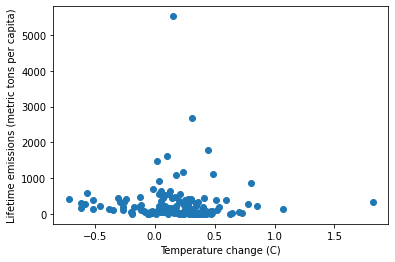

In [8]:
plt.scatter(df['Temperature_change(C)'], df['Lifetime_Emissions(tons/capita)'])
plt.xlabel('Temperature change (C)')
plt.ylabel('Lifetime emissions (metric tons per capita)')
plt.show()

## Correlation

Now it is time to look at our Pearson correlation coefficient. As a reminder, the coefficient is a value ranging from -1 to 1 with:

- -1 meaning negative correlation
- 0 meaning no correlation
- 1 meaning positive correlation

### Advantages

- Indicates the presence or absence of correlation between any two variables and determines the exact extent or degree to which they are correlated.[1]
- Can ascertain the direction of correlation [1]
- Easy to implement in python

### Disadvantages

- Not as quick as other models
- In the case of homogeneous data it can be misinterpreted [1]

In [10]:
correlation = df.corr().loc['Temperature_change(C)', 'Lifetime_Emissions(tons/capita)']
print('Pearson Correlation Coefficient: ', correlation)

Pearson Correlation Coefficient:  -0.033462964195872705


# Summary

As we can see our coefficient is near 0, meaning there is very little correlation between a country's observed temperature change and their lifetime emissions. This proves our hypothesis that there is no meaningful correlation between how much a country pollutes and what it's change in temperature has been.  

Some would say that in a fair world the more developed countries that have emitted more CO2 over their lifetime would face the brunt of the climate crisis. However, as the data shows, the world is not a fair one and we will all face the crisis equally. In fact, it is the lesser-developed and lesser-polluting countries that are more vulnerable due to their poor infrastructure. In this author's opinion, more developed countries need to not only cut back on their emissions (many are already doing so) but be prepared to offer aid to the lesser-developed ones as they weather the crisis that they did not create.

# Bibliography

1. "Pearson's Correlation'. HP, Suresha. https://medium.com/analytics-vidhya/pearsons-correlation-5664e86cf829.
2. "CO2 Emissions (metric tons per capita)". https://data.worldbank.org/indicator/EN.ATM.CO2E.PC
3. http://berkeleyearth.lbl.gov/auto/Global/Raw_TAVG_complete.txt